# Data Preparation

We will follow up on our notes from 'Data Understanding' to prepare a clean data set that we can analyze.

In [774]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

df = pd.read_csv('data/vehicles.csv')
df.shape

(426880, 18)

Let's drop a few columns that we don't need

In [775]:
df.drop(['VIN', 'region', 'state', 'size', 'model'], inplace = True, axis = 1)
df.shape

(426880, 13)

Drop rows without important features

In [776]:
features = ['fuel', 'transmission', 'title_status', 'year', 'type']
df.dropna(subset=features, inplace=True)
df.shape

(322925, 13)

### Handle outliers

Before proceeding, we need to remove some outliers. We will do so by using IQR

<Axes: xlabel='odometer', ylabel='Count'>

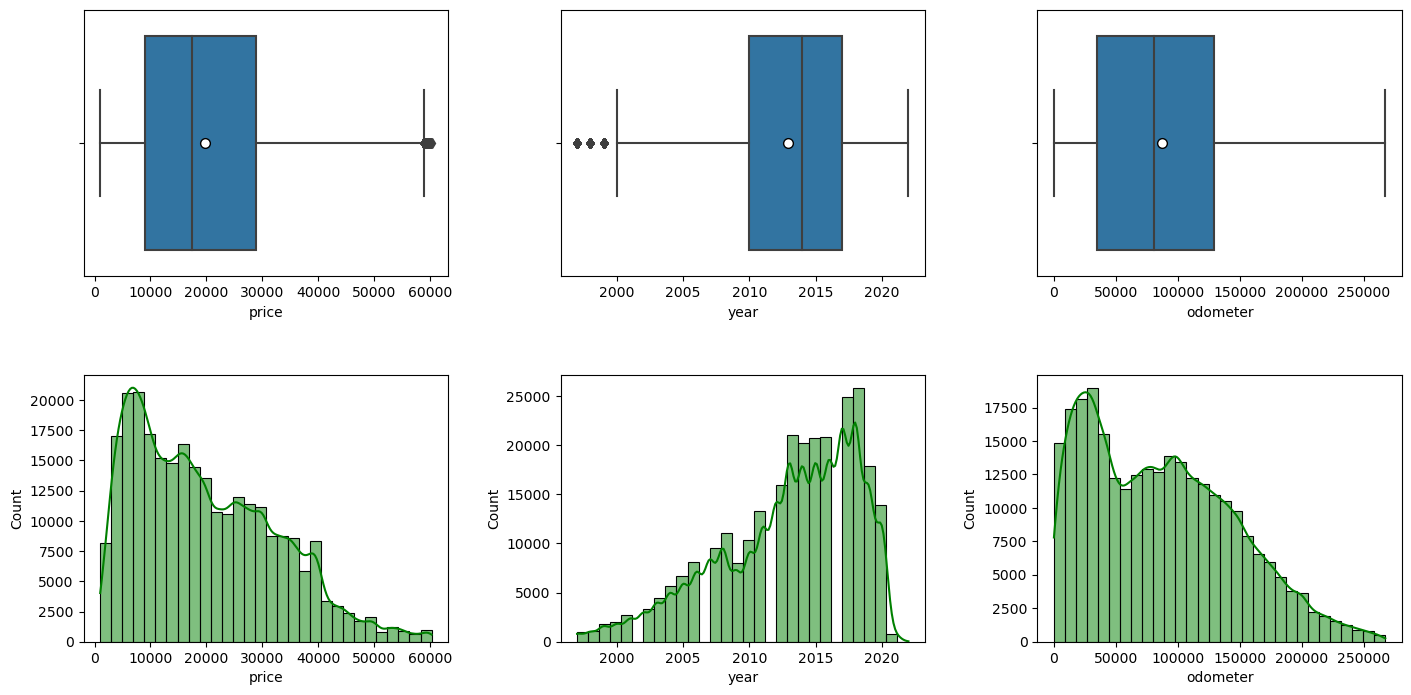

In [777]:
# Create a method to remove outliers using IQR
def remove_outliers_IQR(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    filtered_df = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    
    return filtered_df

df = remove_outliers_IQR(df, 'odometer')
df = remove_outliers_IQR(df, 'year')

# Only keep prices over $1,000
df = remove_outliers_IQR(df[df.price >= 1000], 'price')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
fig.tight_layout(pad=5.0)

mean_props = { 'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'7' }

sns.boxplot(x=df['price'],showmeans=True, meanprops=mean_props, ax=axes[0,0])
sns.boxplot(x=df['year'],showmeans=True, meanprops=mean_props, ax=axes[0,1])
sns.boxplot(x=df['odometer'],showmeans=True, meanprops=mean_props, ax=axes[0,2])
sns.histplot(data=df, x='price',kde=True, color='green',bins=30, ax=axes[1,0])
sns.histplot(data=df, x='year',kde=True, color='green',bins=30, ax=axes[1,1])
sns.histplot(data=df, x='odometer',kde=True, color='green',bins=30, ax=axes[1,2])


### Cylinders
Backfill cylinders using the median value. We will fill `Nan` values, along with those marked as `other`.

In [778]:
# Backfill rows without `cylinders` with the median

# Remove cylinders from the string
df['cylinders'] = df['cylinders'].str.replace('cylinders', '')

# Calculate the median of the cylinders column
cylinders = df.loc[df['cylinders'] != 'other']['cylinders'].dropna()
cylinders = cylinders.astype(int)
cylinders_median = cylinders.median()

# Backfill the missing values with the median
df['cylinders'].fillna(cylinders_median, inplace=True)
df.loc[df['cylinders'] == 'other', 'cylinders'] = cylinders_median

# Cast cylinders to int
df['cylinders'] = df['cylinders'].astype(int)
df[['cylinders']].value_counts(dropna=False)

cylinders
6            164224
4             57224
8             46993
5              1333
10              803
3               417
12               87
dtype: int64

### Odometer
Now let's backfill the `odometer` by using the average distance drived per year in the US. (13,500 miles)

In [779]:
# Create a column age from each row's year
df['age'] = 2021 - df['year']

# Backfill rows without `odometer` by multiplying 13,500 by the age of the car. 
df['odometer'].fillna(df['age'] * 13500, inplace=True)
df['odometer'].value_counts(dropna=False)

200,000.00    768
150,000.00    700
1.00          693
160,000.00    593
140,000.00    586
             ... 
181,235.00      1
84,695.00       1
160,858.00      1
156,106.00      1
163,837.00      1
Name: odometer, Length: 77221, dtype: int64

### Condition
Fill missing `condition` values by looking at other features and assigning a condition. The drawback is that there may be other factors involved. Let's take a look at how condition compares to `odometer` and `age`.

In [780]:
df[['condition']].value_counts(dropna=False)

condition
good         102505
NaN           82805
excellent     67615
like new      14156
fair           3214
new             526
salvage         260
dtype: int64

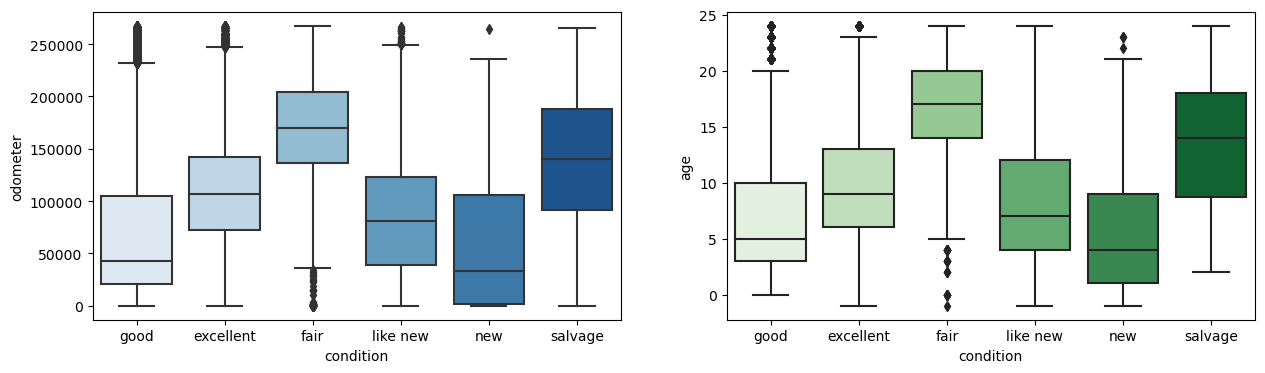

In [781]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
ax = sns.boxplot(x=df['condition'], y=df['odometer'], meanprops=mean_props, ax=axes[0], palette="Blues")
ax = sns.boxplot(x=df['condition'], y=df['age'], meanprops=mean_props, ax=axes[1], palette="Greens")

It seems like `salvage` is not easily distinguised from `fair`, which tells me that there can be other unknown conditions that may deem a car `salvage`. The rest are also pretty close, so I don't think we have enough information to backfill condition. 

Let's keep this variable as a categorical type, and set it as 'other'.

In [782]:
df['condition'].fillna('other', inplace=True)

df.shape

(271081, 14)

### Manufacturer

Given that there is a small number of rows without manufacturer, we can drop rows that are missing it.

In [783]:
count = df['manufacturer'].isna().sum()
print('Number of rows missing manufacturer: {0}'.format(count))

Number of rows missing manufacturer: 6998


In [784]:
# Drop rows without `manufacturer`
df.dropna(subset=['manufacturer'], inplace=True)
df.shape

(264083, 14)

### Drive

In [785]:
drive_counts = df[['drive']].value_counts(normalize=True)
drive_counts

drive
4wd     0.44
fwd     0.38
rwd     0.18
dtype: float64

Let's use the normalized count as a proportion to distribute the remaining values.

In [786]:
def fill_missing_with_existing_distribution(df, column_name):
    # Count the missing values in the column
    missing_count = df[column_name].isna().sum()
    
    # Create a Series object representing the non-null values in the column
    non_nulls = df[column_name].dropna()
    
    # Get unique values and their counts, normalize to create distribution
    unique_values, counts = np.unique(non_nulls, return_counts=True)
    normalized_counts = counts / counts.sum()
    
    # Compute the number of occurrences to fill for each unique value
    fill_counts = (normalized_counts * missing_count).astype(int)
    
    # It's possible that due to integer rounding, we have either over- or under-counted
    # Adjust counts accordingly
    diff = missing_count - fill_counts.sum()
    if diff > 0:
        max_idx = np.argmax(fill_counts)
        fill_counts[max_idx] += diff
    
    # Generate the values that will replace NaNs
    fill_values = np.array([value for value, count in zip(unique_values, fill_counts) for _ in range(count)])
    
    # Create a Series object of the fill values with the index set to the missing rows
    fill_values_series = pd.Series(data=fill_values, index=df[df[column_name].isna()].index[:missing_count])
    
    # Fill in missing values with the generated fill values
    df[column_name].fillna(fill_values_series, inplace=True)

fill_missing_with_existing_distribution(df, 'drive')

drive_counts = df[['drive']].value_counts(dropna=False, normalize=True)
drive_counts


drive
4wd     0.44
fwd     0.38
rwd     0.18
dtype: float64

### Paint color

We will use the same strategy to fill the values of paint color

In [787]:
df['paint_color'].value_counts(dropna=False)

white     56515
black     48904
NaN       42900
silver    33629
blue      23601
red       22176
grey      18818
custom     5064
brown      5010
green      4628
orange     1287
yellow     1125
purple      426
Name: paint_color, dtype: int64

In [788]:
fill_missing_with_existing_distribution(df, 'paint_color')
df['paint_color'].value_counts(dropna=False)

white     67482
black     58389
silver    40151
blue      28178
red       26477
grey      22467
custom     6046
brown      5981
green      5525
orange     1536
yellow     1343
purple      508
Name: paint_color, dtype: int64

### Categorical data

In [790]:
# Change types
df['condition'] = df['condition'].astype('category')
df['fuel'] = df['fuel'].astype('category')
df['title_status'] = df['title_status'].astype('category')
df['transmission'] = df['transmission'].astype('category')
df['drive'] = df['drive'].astype('category')
df['type'] = df['type'].astype('category')
df['paint_color'] = df['paint_color'].astype('category')
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 264083 entries, 27 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   id            264083 non-null  int64   
 1   price         264083 non-null  int64   
 2   year          264083 non-null  float64 
 3   manufacturer  264083 non-null  object  
 4   condition     264083 non-null  category
 5   cylinders     264083 non-null  int64   
 6   fuel          264083 non-null  category
 7   odometer      264083 non-null  float64 
 8   title_status  264083 non-null  category
 9   transmission  264083 non-null  category
 10  drive         264083 non-null  category
 11  type          264083 non-null  category
 12  paint_color   264083 non-null  category
 13  age           264083 non-null  float64 
dtypes: category(7), float64(3), int64(3), object(1)
memory usage: 17.9+ MB


In [792]:
df.drop(['age', 'id'], inplace = True, axis = 1)

## Data exploration

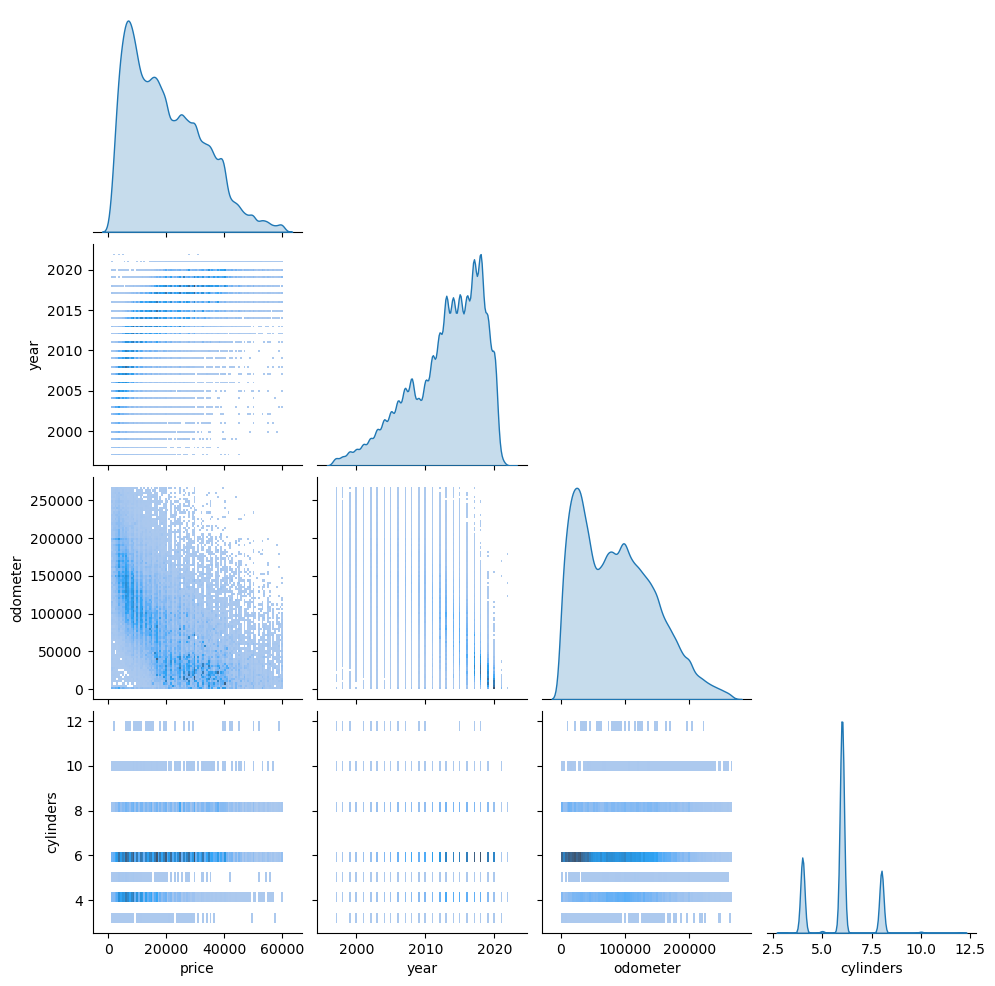

In [791]:
sns.pairplot(df[['price', 'year', 'odometer', 'cylinders']], diag_kind='kde', kind="hist", corner=True)

<Axes: xlabel='drive', ylabel='price'>

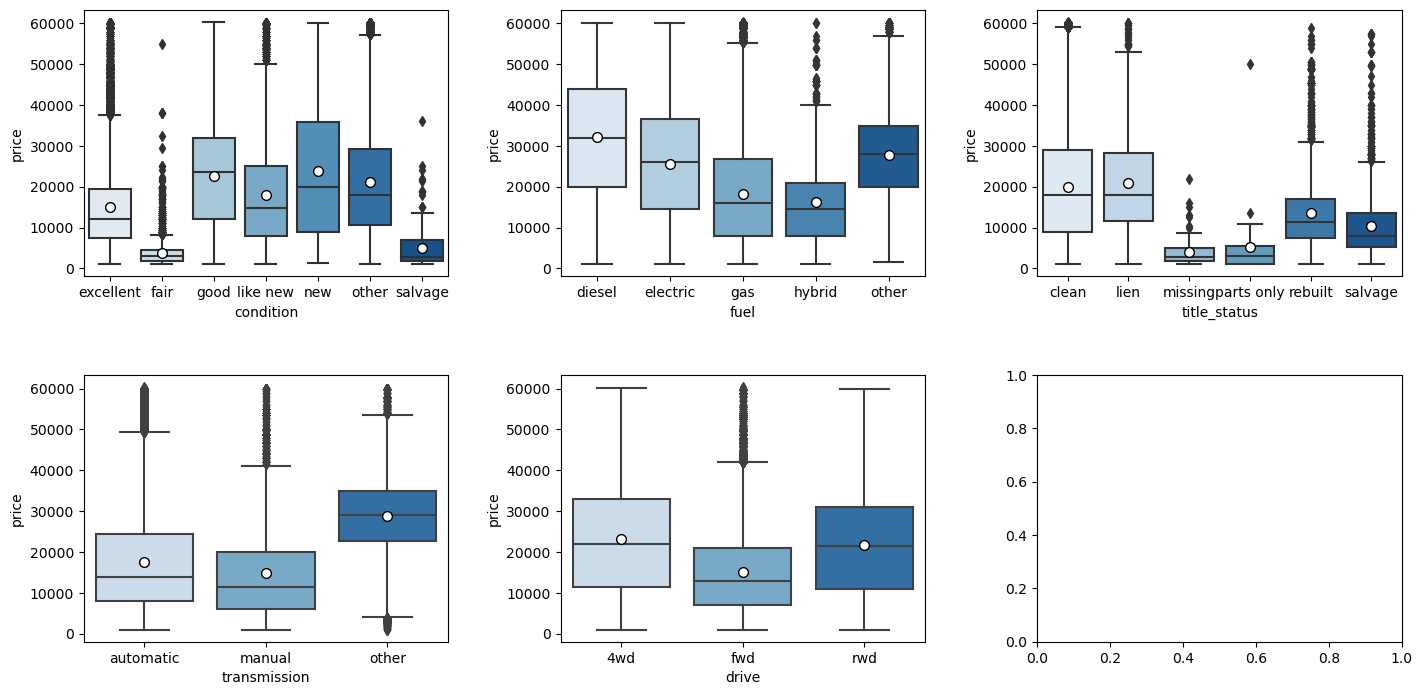

In [793]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))
fig.tight_layout(pad=5.0)

sns.boxplot(data=df, x="condition", y="price", showmeans=True, meanprops=mean_props, ax=axes[0,0], palette="Blues")
sns.boxplot(data=df, x="fuel", y="price", showmeans=True, meanprops=mean_props, ax=axes[0,1], palette="Blues")
sns.boxplot(data=df, x="title_status", y="price", showmeans=True, meanprops=mean_props, ax=axes[0,2], palette="Blues")
sns.boxplot(data=df, x="transmission", y="price", showmeans=True, meanprops=mean_props, ax=axes[1,0], palette="Blues")
sns.boxplot(data=df, x="drive", y="price", showmeans=True, meanprops=mean_props, ax=axes[1,1], palette="Blues")

<Axes: xlabel='paint_color', ylabel='price'>

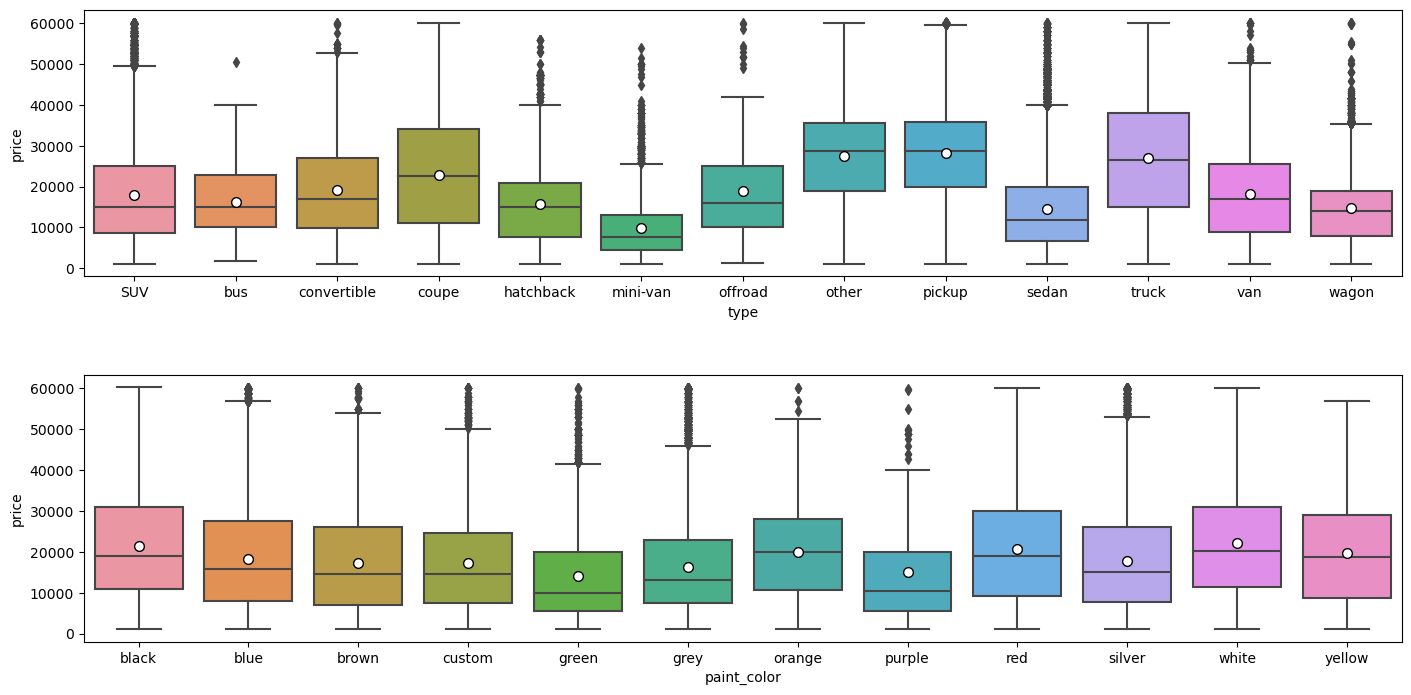

In [794]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,8))
fig.tight_layout(pad=5.0)

sns.boxplot(data=df, x="type", y="price", showmeans=True, meanprops=mean_props, ax=axes[0])
sns.boxplot(data=df, x="paint_color", y="price", showmeans=True, meanprops=mean_props, ax=axes[1])

### Conclusions
1. **Prices** and **year** are correlated. This makes sense, as newer cars are more expensive.
2. **Prices** and **odometer** are negatively correlated. This also makes sense, as cars with more miles are cheaper.
3. **Prices** and **cylinders** are not clearly correlated. I would have expected more cylinders to mean a higher price, but its not always the case.
4. **Prices** and **condition** are correlated, with newer cars being more expensive, but there is a lot of overlap.
5. **Prices** and **fuel** clearly correlated. Diesel cars are more expensive, followed by electric, gas and hybrid.
6. **Prices** and **title_status** are correlated, with clean and lien titles being more expensive.
7. **Prices** and **transmission** are correlated, with automatic cars being more expensive. However, there are lots of outlier due to missing data.
8. **Prices** and **drive** are correlated, with 4wd cars being more expensive, and almost equal to rwd cars.
9. **Prices** and **type** are correlated slightly, with pickups and trucks commanding higher prices
10. **Prices** and **paint_color** don't seem to be much correlated.

## Prepare data for regression

In [795]:
# Let's create some dummy columns for our categoricals. We will need to do this to run more numerical analysis.
# We will leave out manufacturer for now, since there are so many. We can use an encoder for this later

categories = ['condition', 'fuel', 'title_status', 'transmission', 'drive', 'type']

for category in categories:
  dummies = pd.get_dummies(df[category], prefix='{0}_'.format(category))
  df = pd.concat([df, dummies], axis=1)

df.drop(categories, inplace = True, axis = 1)

# We will drop the paing color column, since correlation with price is low.
df.drop(['paint_color'], inplace = True, axis = 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264083 entries, 27 to 426879
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   price                     264083 non-null  int64  
 1   year                      264083 non-null  float64
 2   manufacturer              264083 non-null  object 
 3   cylinders                 264083 non-null  int64  
 4   odometer                  264083 non-null  float64
 5   condition__excellent      264083 non-null  uint8  
 6   condition__fair           264083 non-null  uint8  
 7   condition__good           264083 non-null  uint8  
 8   condition__like new       264083 non-null  uint8  
 9   condition__new            264083 non-null  uint8  
 10  condition__other          264083 non-null  uint8  
 11  condition__salvage        264083 non-null  uint8  
 12  fuel__diesel              264083 non-null  uint8  
 13  fuel__electric            264083 non-null  

In [796]:
# Save the dataset
df.to_csv('data/vehicles_prepared.csv', index=False)